<a href="https://colab.research.google.com/github/hesther/espsim/blob/master/workshop/workshop_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install necessary packages
!pip install rdkit numpy scipy scikit-learn py3dmol
!pip install git+https://github.com/hesther/espsim
!pip install git+https://github.com/hesther/chemprop-atom-bond.git
!pip install git+https://github.com/hesther/ehreact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hesther/espsim to /tmp/pip-req-build-o_s1j7ym
  Running command git clone -q https://github.com/hesther/espsim /tmp/pip-req-build-o_s1j7ym
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hesther/chemprop-atom-bond.git to /tmp/pip-req-build-yix4tmbo
  Running command git clone -q https://github.com/hesther/chemprop-atom-bond.git /tmp/pip-req-build-yix4tmbo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hesther/ehreact to /tmp/pip-req-build-we9kdmm4
  Running command git clone -q https://github.com/hesther/ehreact /tmp/pip-req-build-we9kdmm4


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
import py3Dmol
import ipywidgets
from ipywidgets import interact, interactive, fixed # For interactive display of conformers

from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim
from espsim.helpers import mlCharges

import ehreact
from ehreact.train import calculate_diagram
from ehreact.predict.make_prediction import find_highest_template

import urllib.request
import gzip
from copy import deepcopy
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def draw(ms,p=None, confIds=None):
    if p is None:
        p = py3Dmol.view(width=400, height=400)
    if confIds is None:
        confIds = [-1]*len(ms)
    p.removeAllModels()
    for i,m in enumerate(ms):
        mb=Chem.MolToMolBlock(m, confId=confIds[i])
        p.addModel(mb, 'sdf')
        p.setStyle({'model':i},{'stick':{'radius':0.15}})
    p.setBackgroundColor('white')#'0xeeeeee')
    p.zoomTo()
    return p.show()

def tree_traversal(node, ctr=1):
    if(node != None):
        print('     ' * (ctr-1), "|...", node)
        for child_node in [edge.child_node for edge in node.edges_to_child]:
            tree_traversal(child_node, ctr+1)

def align(prbMol, refMol, prbCrippen=None, refCrippen=None, i=-1, j=-1):
    if prbCrippen is None:
        prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    if refCrippen is None:
        refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)
    alignment = rdMolAlign.GetCrippenO3A(prbMol, refMol, prbCrippen, refCrippen, i, j)
    alignment.Align()

def embed(mol,n=10):
    if mol is not None:
        ps = AllChem.ETKDGv2()
        ps.useRandomCoords=False
        AllChem.EmbedMultipleConfs(mol, n, ps)
        if mol.GetNumConformers() != n:
            print("could not embed, trying random coordinates for initialization")
            ps.useRandomCoords=True
            AllChem.EmbedMultipleConfs(mol, n, ps)
        if mol.GetNumConformers() != n:
            print("could not embed")
            return None
    return mol

# **Example 1:** EC 1.1.3.2 (Lactate oxidase)

For lactate oxidase, the following substrates are known. The enzyme catalyses the oxidation of the hydroxyl group next to the carboxylic acid with oxygen.

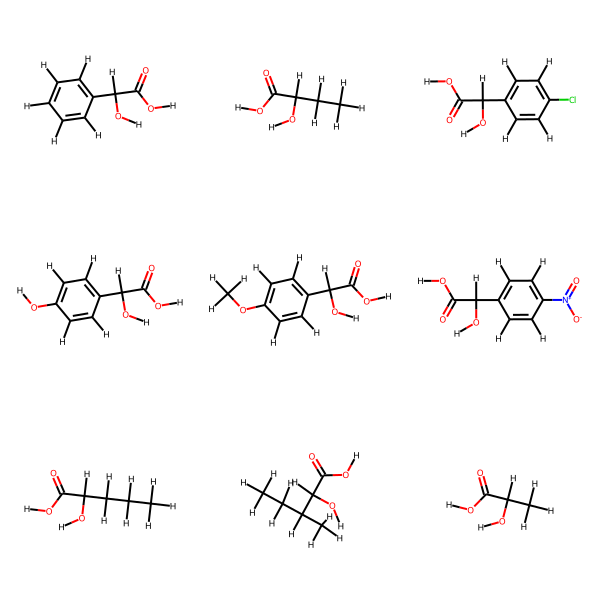

In [ ]:
refSmiles=['C1=CC=C(C=C1)C(C(=O)O)O','CCC(C(=O)O)O','OC(C(O)=O)c1ccc(Cl)cc1','C1=CC(=CC=C1C(C(=O)O)O)O','COc1ccc(cc1)C(O)C(O)=O','OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O','CCCC(C(=O)O)O','CCC(C)C(C(=O)O)O','CC(C(=O)O)O']
refMols=[Chem.AddHs(Chem.MolFromSmiles(x)) for x in refSmiles]
Draw.MolsToGridImage(refMols)

The following substrate is also known to be active. Let's try to score it's shape and ESP similarity to the 9 known substrates:

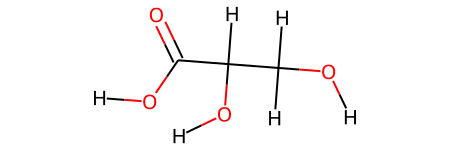

In [ ]:
prbSmile='C(C(C(=O)O)O)O'
prbMol=Chem.AddHs(Chem.MolFromSmiles(prbSmile))
prbMol

We first use the default ESPsim method to embed all molecules, align pairs of reference and probe molecules and score them, namely the function **EmbedAlignScore()**

In [ ]:
simShape, simEsp = EmbedAlignScore(prbMol, refMols, renormalize=True)
print('%35s %8s %8s %8s' % ("Reference","Shape","ESP", "Shape*ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i],simShape[i]*simEsp[i]))

                          Reference    Shape      ESP Shape*ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.65     0.85     0.55
                       CCC(C(=O)O)O     0.94     0.87     0.82
             OC(C(O)=O)c1ccc(Cl)cc1     0.56     0.67     0.38
           C1=CC(=CC=C1C(C(=O)O)O)O     0.60     0.51     0.31
             COc1ccc(cc1)C(O)C(O)=O     0.55     0.69     0.38
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.53     0.66     0.35
                      CCCC(C(=O)O)O     0.82     0.89     0.74
                   CCC(C)C(C(=O)O)O     0.73     0.87     0.64
                        CC(C(=O)O)O     0.89     0.93     0.82


Let's inspect some of the embedded conformations (they will all be aligned to the last conformer, since we overwrite the alignments:

In [ ]:
p = py3Dmol.view(width=400,height=400)
dt = {}
for i in range(len(refMols)):
  dt[i] = [prbMol, refMols[i]]
interact(draw, ms=dt,p=fixed(p),confIds=fixed([-1,-1]));

interactive(children=(Dropdown(description='ms', options={0: [<rdkit.Chem.rdchem.Mol object at 0x7fadff6b7ad0>…

We get a maximum score of about 0.8, and see that some of the alignments are not great.

Also, we note that this was very easy. **EmbedAlignScore** allows for a number of customizations, for example the number of embedded conformers for the probe and reference molecules (**prbNumConfs** and **refNumConfs**, per default 10 each), the similarity method and integration routine (**metric**, **integrate** and **renormalize**) or whether to compute ESP similarities for all conformations instead of just the one with the highest shape similarity (**getBestESP**). Let's try to add more conformers:

In [ ]:
simShape, simEsp = EmbedAlignScore(prbMol, refMols, renormalize=True, refNumConfs = 50)
print('%35s %8s %8s %8s' % ("Reference","Shape","ESP", "Shape*ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i],simShape[i]*simEsp[i]))

                          Reference    Shape      ESP Shape*ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.64     0.74     0.48
                       CCC(C(=O)O)O     0.95     0.70     0.67
             OC(C(O)=O)c1ccc(Cl)cc1     0.57     0.84     0.48
           C1=CC(=CC=C1C(C(=O)O)O)O     0.60     0.76     0.46
             COc1ccc(cc1)C(O)C(O)=O     0.55     0.68     0.38
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.53     0.65     0.34
                      CCCC(C(=O)O)O     0.83     0.75     0.62
                   CCC(C)C(C(=O)O)O     0.74     0.87     0.64
                        CC(C(=O)O)O     0.89     0.87     0.78


The code now takes longer to evaluate, and we might find slightly better scores for some reference molecules. In general: The more conformers, the larger the scores, because we can find pairs of conformers with better overlap. However, as the embedding is stochastic, there is no guarantee for finding a good conformation.

Let's also try to return the best ESP similarity instead of the ESP similarity at the best shape score:

In [ ]:
simShape, simEsp = EmbedAlignScore(prbMol, refMols, renormalize=True, getBestESP=True)
print('%35s %8s %8s %8s' % ("Reference","Shape","ESP", "Shape*ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i],simShape[i]*simEsp[i]))

                          Reference    Shape      ESP Shape*ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.64     0.90     0.58
                       CCC(C(=O)O)O     0.95     0.91     0.87
             OC(C(O)=O)c1ccc(Cl)cc1     0.57     0.89     0.51
           C1=CC(=CC=C1C(C(=O)O)O)O     0.60     0.87     0.52
             COc1ccc(cc1)C(O)C(O)=O     0.54     0.84     0.46
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.53     0.75     0.39
                      CCCC(C(=O)O)O     0.82     0.93     0.77
                   CCC(C)C(C(=O)O)O     0.73     0.91     0.67
                        CC(C(=O)O)O     0.89     0.92     0.82


Now the ESP scores are higher, while the shape scores are lower (because we didn't select the best shape alignment pair).

In all cases, the scores to some of the reference molecules are quite high, and we can assume that the substrate is probably processed by lactate oxidase.

Let's also try a molecule that is not probably not processed by lactate oxidase:

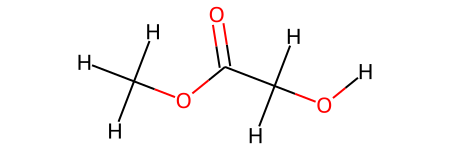

In [ ]:
prbSmile2='C(C(=O)OC)O'
prbMol2=Chem.AddHs(Chem.MolFromSmiles(prbSmile2))
prbMol2

In [ ]:
simShape, simEsp = EmbedAlignScore(prbMol2, refMols, renormalize=True)
print('%35s %8s %8s %8s' % ("Reference","Shape","ESP", "Shape*ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i],simShape[i]*simEsp[i]))

                          Reference    Shape      ESP Shape*ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.59     0.61     0.36
                       CCC(C(=O)O)O     0.79     0.57     0.45
             OC(C(O)=O)c1ccc(Cl)cc1     0.52     0.58     0.30
           C1=CC(=CC=C1C(C(=O)O)O)O     0.54     0.56     0.30
             COc1ccc(cc1)C(O)C(O)=O     0.50     0.55     0.27
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.48     0.44     0.21
                      CCCC(C(=O)O)O     0.69     0.56     0.39
                   CCC(C)C(C(=O)O)O     0.63     0.49     0.31
                        CC(C(=O)O)O     0.70     0.92     0.64


This time, we get scores that are lower (about 0.6 for the combined shape and ESP similarity, with some scores being much lower)

However, we can get even better estimates if we constrain the alignment, because we know the active center of each substrate for the oxidation reaction, i.e. know that these parts of the molecules need to be docked in the same position in the active pocket. We can define this region by hand or use a software such as EHreact to find the best fragment.

We can use EHreact to create a Hasse diagram, and find the highest matching substructure for our two probe molecules:

In [ ]:
d=calculate_diagram(refSmiles,train_mode='single_reactant',seed=['[H]OC[H]'],no_props=True)
tree_traversal(d.nodes[''])

 |... root
      |... [H]CO[H]
           |... [H]OC([H])(C)C
                |... [H]OC([H])(C)C(O)=O
                     |... [H]OC(=O)C([H])(C)O[H]
                          |... [H]OC(=O)C([H])(O[H])C([H])(C)C
                               |... [H]OC(=O)C([H])(O[H])C([H])(C([H])([H])[H])C([H])([H])C
                                    |... [H]OC(=O)C([H])(O[H])C([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H]
                          |... [H]OC(=O)C([H])(O[H])C([H])([H])C
                               |... [H]OC(=O)C([H])(O[H])C([H])([H])C([H])([H])C
                                    |... [H]OC(=O)C([H])(O[H])C([H])([H])C([H])([H])C([H])([H])[H]
                               |... [H]OC(=O)C([H])(O[H])C([H])([H])C([H])([H])[H]
                          |... [H]OC(=O)C([H])(O[H])C([H])([H])[H]
                          |... [H]OC(=O)C([H])(O[H])c1ccccc1
                               |... [H]OC(=O)C([H])(O[H])c1c([H])c([H])cc([H])c1[H]
                                    |... [H

The maximum common pattern for all reference molecules is [H]OC(=O)C([H])(C)O[H], however, this does not mean that our probe molecules also fit this pattern (the first one does, the second doesn't), so ideally we find the maximum common core around the reactive center for each query:

[H]OC(=O)C([H])(C)O[H]


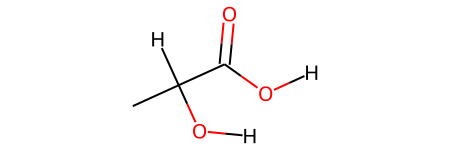

In [ ]:
template = find_highest_template(d.nodes[''], prbMol, d, '')
print(template)
d.nodes[template].rule

The constrained embedding routine in ESPsim expects us to provide the core with 3D coordinates. An easy way to obtain those is to embed one of the reference molecules and cut out the core atoms:

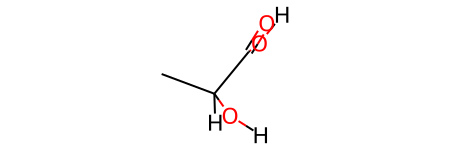

In [ ]:
AllChem.EmbedMolecule(refMols[0],AllChem.ETKDG()) #Embed first reference molecule, create one conformer
AllChem.UFFOptimizeMolecule(refMols[0]) #Optimize the coordinates of the conformer
core = AllChem.DeleteSubstructs(AllChem.ReplaceSidechains(refMols[0],d.nodes[template].rule),Chem.MolFromSmiles('*')) #Create core molecule with 3D coordinates
core.UpdatePropertyCache()
core

In [ ]:
simShape,simEsp=EmbedAlignConstrainedScore(prbMol,refMols,core, renormalize=True)
print('%35s %8s %8s %8s' % ("Reference","Shape","ESP", "Shape*ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i],simShape[i]*simEsp[i]))

                          Reference    Shape      ESP Shape*ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.64     0.90     0.58
                       CCC(C(=O)O)O     0.96     0.88     0.84
             OC(C(O)=O)c1ccc(Cl)cc1     0.57     0.90     0.51
           C1=CC(=CC=C1C(C(=O)O)O)O     0.60     0.78     0.47
             COc1ccc(cc1)C(O)C(O)=O     0.55     0.72     0.39
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.53     0.68     0.36
                      CCCC(C(=O)O)O     0.83     0.89     0.74
                   CCC(C)C(C(=O)O)O     0.73     0.87     0.63
                        CC(C(=O)O)O     0.89     0.87     0.77


We can inspect the embedded molecules (here conformation 0 for each molecule, not the best conformer). They all have the same coordinates for the pre-defined core containing the reactive center. The second cell plots the first reference molecule together with the probe molecule in all possible conformations.

In [ ]:
draw(refMols)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
p = py3Dmol.view(width=400,height=400)
dt = {}
for i in range(len(refMols)):
  dt[i] = [prbMol, refMols[i]]
interact(draw, ms=dt,p=fixed(p),confIds=fixed([-1,-1]));

interactive(children=(Dropdown(description='ms', options={0: [<rdkit.Chem.rdchem.Mol object at 0x7fadff6b7ad0>…

The scores are now higher (since we found a better alignment via expert knowledge of the docking position), and in many cases also more reliable. Ideally, we would have used a docked configuration of one of the reference molecules for creating the core 3D coordinates, not just a random embedding, to get even more reliable scores.

Let's now test the second query molecule, which has a much smaller common core (since the carbon is not secondary):

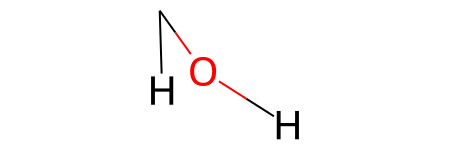

In [ ]:
template = find_highest_template(d.nodes[''], prbMol2, d, '')
core = AllChem.DeleteSubstructs(AllChem.ReplaceSidechains(refMols[0],d.nodes[template].rule),Chem.MolFromSmiles('*')) #Create core molecule with 3D coordinates
core.UpdatePropertyCache()
core

In [ ]:
simShape,simEsp=EmbedAlignConstrainedScore(prbMol,refMols,core, renormalize=True)
print('%35s %8s %8s %8s' % ("Reference","Shape","ESP", "Shape*ESP"))
for i in range(len(refSmiles)):
    print('%35s %8.2f %8.2f %8.2f' % (refSmiles[i],simShape[i],simEsp[i],simShape[i]*simEsp[i]))

                          Reference    Shape      ESP Shape*ESP
            C1=CC=C(C=C1)C(C(=O)O)O     0.43     0.75     0.32
                       CCC(C(=O)O)O     0.52     0.86     0.45
             OC(C(O)=O)c1ccc(Cl)cc1     0.38     0.77     0.29
           C1=CC(=CC=C1C(C(=O)O)O)O     0.40     0.69     0.28
             COc1ccc(cc1)C(O)C(O)=O     0.37     0.73     0.27
   OC(C(O)=O)c1ccc(cc1)[N+]([O-])=O     0.36     0.66     0.24
                      CCCC(C(=O)O)O     0.56     0.70     0.40
                   CCC(C)C(C(=O)O)O     0.58     0.64     0.37
                        CC(C(=O)O)O     0.56     0.77     0.43


As expected, the scores are rather poor, and we can assume that this query is not processed by lacatate oxidase.

# ***Example 2:*** Influence of metric, integration routine and partialCharges

To study the behavior of the similarity metric, integration routine and partialCharges, let's embed and align two molecules, and then call the similarity routine multiple times. For simplicity, we will only create one conformer per molecule.

In [ ]:
m1 = Chem.AddHs(Chem.MolFromSmiles("c1ccccc1Cl"))
m2 = Chem.AddHs(Chem.MolFromSmiles("c1ccccc1[N+]([O-])=O"))

m1 = embed(m1, n=1)
m2 = embed(m2, n=1)

draw([m1,m2])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
align(m1,m2)
draw([m1,m2])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
print('%10s %10s %10s %10s' % ("Metric","Integrate","Charges", "ESP sim"))
for metric in ['carbo', 'tanimoto']:
  for integrate in ['gauss', 'mc']:
    for partialCharges in ['gasteiger', 'mmff', 'ml']:
      sim = GetEspSim(m1, m2, metric = metric, integrate = integrate, partialCharges = partialCharges)
      print('%10s %10s %10s  %10.2f' % (metric, integrate, partialCharges, sim))


    Metric  Integrate    Charges    ESP sim
     carbo      gauss  gasteiger        0.56
     carbo      gauss       mmff        0.51
     carbo      gauss         ml        0.59
     carbo         mc  gasteiger        0.80
     carbo         mc       mmff        0.76
     carbo         mc         ml        0.81
  tanimoto      gauss  gasteiger        0.15
  tanimoto      gauss       mmff        0.27
  tanimoto      gauss         ml        0.20
  tanimoto         mc  gasteiger        0.20
  tanimoto         mc       mmff        0.41
  tanimoto         mc         ml        0.25


We see that within one metric and integration routine, the charge distribution plays only a minor role for the obtained ESP similarity score.

The metric (Carbo or Tanimoto), can play a large role, with Tanimoto scores usually being lower (since it also penalizes differences in the magnitude of the ESPs).

The integration routine further influences the results, since it compares the ESPs only in a certain region, not the full space.

For a given project, it is thus very important to stick to one metric and integration routine (and report it!), as the applicability of ESP similarity scores lies more in relative than absolute comparisons!

For Monte Carlo integration, the size of the integration box and the number of integration points per cubic angstrom also play a role:

In [ ]:
print('%10s %10s %10s' % ("Box size","point dens.", "ESP sim"))
for marginMC in [2, 5, 10, 20]:
  for nMC in [1,2,5,10]:
    sim = GetEspSim(m1, m2, metric = 'carbo', integrate = 'mc', partialCharges = 'gasteiger', marginMC=marginMC, nMC=nMC)
    print('%10i %10i %10.2f' % (marginMC, nMC, sim))

  Box size point dens.    ESP sim
         2          1       0.04
         2          2       0.27
         2          5       0.26
         2         10       0.31
         5          1       0.58
         5          2       0.57
         5          5       0.52
         5         10       0.53
        10          1       0.76
        10          2       0.77
        10          5       0.78
        10         10       0.76
        20          1       0.77
        20          2       0.82
        20          5       0.79
        20         10       0.81


The smaller the box, the more the overlap integral focusses on regions close to the atoms (which usually gives lower scores). Ideally, the box size would be chosen to mimic the approximate size of a binding pocket.

With increasing point density, the overlap integral usually converges. More points take longer to compute, but yield less noisy results.





# Example 3: Docking (target from DUD-E)

In [ ]:
name = 'ampc'

print("Download actives, decoys and ligand")
urllib.request.urlretrieve('http://dude.docking.org/targets/'+name+'/actives_final.sdf.gz', name+'_actives.sdf.gz')
urllib.request.urlretrieve('http://dude.docking.org/targets/'+name+'/decoys_final.sdf.gz', name+'_decoys.sdf.gz')
urllib.request.urlretrieve('http://dude.docking.org/targets/'+name+'/crystal_ligand.mol2', name+'_ligand.mol2')

print("Reading in files")
inf = gzip.open(name+'_actives.sdf.gz')
gzsuppl= Chem.ForwardSDMolSupplier(inf)
mols = [Chem.AddHs(mol,addCoords=True) for mol in gzsuppl if mol is not None]
inf.close()

#For the purpuse of this tutorial, we will only use 60 decoys (which is about the number of actives). For a real benchmark, use all!
inf = gzip.open(name+'_decoys.sdf.gz')
gzsuppl= Chem.ForwardSDMolSupplier(inf)
decoys = [Chem.AddHs(mol,addCoords=True) for mol in gzsuppl if mol is not None][-60:]
inf.close() 

ligand = Chem.MolFromMol2File(name+'_ligand.mol2')
ligand = Chem.AddHs(ligand,addCoords=True)

Download actives, decoys and ligand
Reading in files


Let's inspect the ligand in it's crystallized form, the active molecules and decoys:

In [ ]:
draw([ligand])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
p = py3Dmol.view(width=400,height=400)
dt = {}
for i in range(len(mols)):
  dt[i] = [mols[i]]
interact(draw, ms=dt,p=fixed(p),confIds=fixed([-1,-1]));

interactive(children=(Dropdown(description='ms', options={0: [<rdkit.Chem.rdchem.Mol object at 0x7ff53c7e5d50>…

In [ ]:
p = py3Dmol.view(width=400,height=400)
dt = {}
for i in range(len(decoys)):
  dt[i] = [decoys[i]]
interact(draw, ms=dt,p=fixed(p),confIds=fixed([-1,-1]));

interactive(children=(Dropdown(description='ms', options={0: [<rdkit.Chem.rdchem.Mol object at 0x7ff53c7a4170>…

Let's first use the given embeddings in the downloaded sdf files to align and score all molecules:

In [ ]:
def AlignScore(prbMol,refMol,prbCharge,refCharge):
    #Need to copy mols, otherwise the alignment will change the positions of the molecule object permanently                                                                                                                               
    prbMol=deepcopy(prbMol)
    refMol=deepcopy(refMol)

    prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)

    #Get best conformer
    best_score=0
    best_i=0
    for i in range(prbMol.GetNumConformers()):
        align(prbMol, refMol, prbCrippen, refCrippen, i, 0)
        shape = GetShapeSim(prbMol,refMol,i,0)
        if shape>best_score:
            best_score=shape
            best_i=i

    #Use best conformer for scoring
    align(prbMol, refMol, prbCrippen, refCrippen, best_i, 0)
    shape = GetShapeSim(prbMol,refMol,best_i,0)
    esp=GetEspSim(prbMol,refMol,best_i,0,prbCharge=prbCharge,refCharge=refCharge,metric='tanimoto')

    return shape+esp

In [ ]:
#Precomputing ML charges is much faster than calculation on the fly since there is substantial overhead with loading the model
prbCharges=mlCharges(mols+decoys)
refCharge=mlCharges([ligand])[0]

In [ ]:
scores = [AlignScore(m,ligand,prbCharges[i],refCharge) for i,m in enumerate(mols + decoys)]
metrics.roc_auc_score([1]*len(mols)+[0]*len(decoys), scores)

0.7666666666666666

However, using just one single conformer per molecule usually leads to very poor alignments. Let's embed 10 conformers each and use the best for scoring:

In [ ]:
mols = [embed(mol,n=10) for mol in mols]
mols = [mol for mol in mols if mol is not None]  

decoys = [embed(mol,n=10) for mol in decoys]
decoys = [mol for mol in decoys if mol is not None]

Embedding 62 actives
... yielding 62 embedded actives
Embedding 60 decoys
... yielding 60 embedded actives


In [ ]:
scores = [AlignScore(m,ligand,prbCharges[i],refCharge) for i,m in enumerate(mols + decoys)]
metrics.roc_auc_score([1]*len(mols)+[0]*len(decoys), scores)

0.8440860215053764

Using more conformations usually gives a higher probability of finding a good alignment, so that a poor score is due to a poor similarity, not a poor alignment, which reduces noise.

We can also try to embed more conformations, e.g 30 (but 10 proved to be quite ok in our benchmarks!):

In [ ]:
mols = [embed(mol,n=30) for mol in mols]
mols = [mol for mol in mols if mol is not None]  

decoys = [embed(mol,n=30) for mol in decoys]
decoys = [mol for mol in decoys if mol is not None]  

Embedding 62 actives
... yielding 62 embedded actives
Embedding 60 decoys
... yielding 60 embedded actives


In [ ]:
scores = [AlignScore(m,ligand,prbCharges[i],refCharge) for i,m in enumerate(mols + decoys)]
metrics.roc_auc_score([1]*len(mols)+[0]*len(decoys), scores)

0.8661290322580645

We can also evaluate the accuracy of a classification model using the optimal threshold to balance sensitivity and specificity:

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve([1]*len(mols)+[0]*len(decoys), scores)
metrics.accuracy_score([1]*len(mols)+[0]*len(decoys), [s>thresholds[np.argmax(tpr - fpr)] for s in scores])

0.8360655737704918

We thus get a model with a ROC-AUC score of 0.87 and an accuracy of classifying between actives and decoys of 0.84 (which is pretty good, but of course there are also targets in DUD-E where ESPsim performs less well!)

Let's plot the scores of actives and decoys:

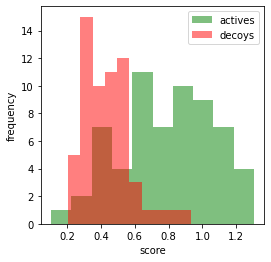

In [ ]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

ax.set_xlabel('score')
ax.set_ylabel('frequency')
ax.hist(scores[:len(mols)],  label = 'actives', color = 'green', alpha=0.5)
ax.hist(scores[len(mols):], label = 'decoys', color = 'red', alpha=0.5)
ax.legend()

# Summary

Summing up, this workshop shows how to:

* Embed, align and compute Shape and ESP similarities on molecules without any constraints in a single function call (Example 1)
* Constrained-embed,  align and compute Shape and ESP similarities on molecules with a common core in a single function call (Example 1)
* Compute ESP similarities on pre-aligned molecules (Example 2)
* Choose options for integration routine, metric and partial charges (Example 2)
* Score actives and decoys in a docking study by computing similarities to a known, docked ligand via pre-embedded molecules or via newly embedding molecules (Example 3)
* Write your own alignment and scoring functions customized to a problem (Example 3)

We hope this workshop was helpful to you! Feel free to reach out on [GitHub](https://github.com/hesther/espsim) or via email (esther.heid@tuwien.ac.at) for further questions or suggestions!

Also, if you find ESPsim useful, please remember to cite us: **G. Bolcato, E. Heid and J. Boström, J. Chem. Inf. Model. 2022, 62, 6, 1388–1398**